## Introduction

Recently, Ted Cruz won shocked by winning Iowa caucus over Donald Trump. Also, Hillary Clinton and Bernie Sanders came very close to each other than what was expected out of the polls. 

I read about the various reasons why polls may not be a correct indicator anymore in our days of internet and mobile phones. I have seen various posts wherein folks apply data science to Twitter feed in order to gauge favorability of presidential candidates. So, rather than repeating what has already been done (and proven to provide good results), I decided to pursue something new. 

I have been viewing speeches and debates on youtube and  so, I wanted to analyze dataset from youtube API in order to see if statistics about youtube videos could serve as any reasonable indicator. 

The following code walk through is as follows:
1.	We import all the necessary libraries
2.	We would set up our connection to youtube 
3.	We search youtube for four candidates of interest: Hillary Clinton and Bernie Sanders on Democratic side; Donald Trump and Ted Cruz on Republican side
and gather small list of video_ids for each of these candidates
4.	We gather some relevant statistics coming through youtube API: number of videos published, number of views, number of likes and dislikes, number of favorites
5.	We then plot these results and try to see if these stats could serve as decent indicators


## Step 1: Import Necessary Libraries

In [103]:
import warnings
warnings.filterwarnings('ignore')

import requests
import matplotlib.pyplot as plt
import json
import pandas as pd
import datetime

%matplotlib inline

## Step 2: Extract data using youtube API

### Search youtube videos

In [104]:
def load_search_results(api_key, query, order = 'viewCount', page_token = '', 
                   published_before_date = None, published_after_date = None):
    """Returns details about youtube videos for searched query
    
    Input:
    ------
    query : string 
    search item 
    
    order: string
    order of sorting for results 
    possible values: 'viewCount', 'relevance', 'date', 'rating', 'title', 'videoCount'
    default: 'viewCount'
    
    page_token: string
    string token to select results page
    default: ''
    
    published_before_date: datetime
    returns all videos published before this date
    default: None
    
    published_after_date: datetime
    returns all videos published after this date
    default: None
    
    api_key: string
    your api key 
    """
    
    param_dict = parameters = {'key': my_api_key,
                             'maxResults': 50,
                             'order': 'viewCount',
                             'pageToken': '',
                             'part': 'id',
                             'publishedAfter': published_after_date,
                             'publishedBefore': published_before_date,
                             'q': query,
                             'type': 'video'}
    response = requests.request(method = 'GET', url = 'https://www.googleapis.com/youtube/v3/search', 
                                    params = param_dict)
    search_results = response.json()
    return search_results

def search_youtube(api_key, query = '', published_before_date = None, published_after_date = None, num_requests = 10):
    page_token = ''
    video_ids = []
    print ('current query:', query)
    for num in range(num_requests):
        results = load_search_results(api_key, query, order = 'viewCount', page_token = '', 
                   published_before_date = published_before_date, published_after_date = published_after_date)
        if 'items' in results:
            for i in range(len(results['items'])):
                video_ids.append(results['items'][i]['id']['videoId'])
        if 'nextPageToken' in results:
            page_token = results['nextPageToken']
    return video_ids

### Extract stats for youtube videos

In [105]:
def load_video_stats(video_id_list, api_key):
    """Returns detailed statistics about a given video
    
    Input:
    ------
    video_id : string 
    video for which statistics will be returned
    
    api_key: string
    your api key 
    """
    
    param_dict = {'part': 'statistics', 
                  'id': ','.join(video_id_list), 
                  'key': api_key}
    page_results = requests.request(method = 'GET', url = 'https://www.googleapis.com/youtube/v3/videos', 
                                    params = param_dict)
    video_stats = page_results.json()
    df_results = pd.DataFrame(item['id'] for item in video_stats['items'])
    df_results['comment_count'] = [item['statistics'].get('commentCount', 0) for item in video_stats['items']]
    df_results['favorite_count'] = [item['statistics'].get('favoriteCount', 0) for item in video_stats['items']]
    df_results['like_count'] = [item['statistics'].get('likeCount', 0) for item in video_stats['items']]
    df_results['dislike_count'] = [item['statistics'].get('dislikeCount', 0) for item in video_stats['items']]
    df_results['view_count'] = [item['statistics'].get('viewCount', 0) for item in video_stats['items']]
    df_results[['comment_count', 'favorite_count', 'like_count', 'dislike_count', 'view_count']] = df_results[['comment_count', 'favorite_count', 'like_count', 'dislike_count', 'view_count']].astype(int)
    param_dict['part'] = 'snippet'
    page_results = requests.request(method = 'GET', url = 'https://www.googleapis.com/youtube/v3/videos', 
                                    params = param_dict)
    video_snippet = page_results.json()
    df_results['title'] = [item['snippet']['title'] for item in video_snippet['items']]
    df_results['published_at'] = [item['snippet']['publishedAt'] for item in video_snippet['items']]
    df_results['published_at'] = df_results['published_at'].map(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.000Z"))
    df_results['date'] = df_results['published_at'].map(lambda x: x.date())
    df_results['week'] = df_results['date'].map(lambda x: x.isocalendar()[1])
    df_results['channel_id'] = [item['snippet']['channelId'] for item in video_snippet['items']]
    df_results['category_id'] = [item['snippet']['categoryId'] for item in video_snippet['items']]
    df_results['channelTitle'] = [item['snippet']['channelTitle'] for item in video_snippet['items']]
    
    return df_results

def video_statistics(video_id_list, api_key):
    result = []
    for index, item in enumerate(video_id_list[::50]):
        t_index = index * 50
        result.append(load_video_stats(video_id_list[t_index:t_index + 50], api_key))
    return pd.concat(result)

## Step 3: Get relevant stats and plot data

In [106]:
def extract_data(candidates_list, published_before_date, published_after_date, api_key):
    results_list = []
    for candidate in candidates_list:
        results = search_youtube(api_key, query=candidate,
                              published_before_date=published_before_date,
                              published_after_date=published_after_date,
                              num_requests = 50)

        stat_data_set = video_statistics(results, api_key)
        stat_data_set["candidate_name"] = candidate
        results_list.append(stat_data_set)
    data_set = pd.concat(results_list)
    return data_set



In [123]:
republican_candidates = ['Donald Trump', 'Ted Cruz']
democratic_candidates = ['Bernie Sanders', 'Hillary Clinton']
my_api_key = 'api_key'

republican_presidential_data =  extract_data(republican_candidates,'2015-12-01T00:00:00Z' , '2016-02-01T00:00:00Z', my_api_key)

democratic_presidential_data =  extract_data(democratic_candidates,'2015-12-01T00:00:00Z' , '2016-02-01T00:00:00Z', my_api_key)

presidential_data = republican_presidential_data.append(democratic_presidential_data)
table = pd.pivot_table(presidential_data, index = 'candidate_name', 
                      values = ['comment_count', 'dislike_count', 'like_count', 'view_count'], 
                     aggfunc = 'sum')
table.sort(['comment_count', 'dislike_count', 'like_count', 'view_count'])

,comment_count,dislike_count,like_count,view_count
candidate_name,,,,
Ted Cruz,5110489,3573450,9019968,1670678750
Bernie Sanders,13958450,3050737,28563118,2520883500
Hillary Clinton,17900600,8238044,37960641,14013807100
Donald Trump,28820074,18383013,125285053,18895713900


### Observations:  
1. On the Republican side, Donald Trump far outpaced Ted Cruz across all stats and yet, came to the top at Iowa
2. On the Democrat side, Hillary Clinton and Bernie Sanders have been fairly close in terms of comment count and like counts. However, seems like Hillary Clinton's videos have got far more views as compared to that of Bernie Sanders

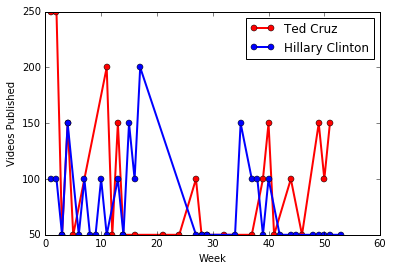

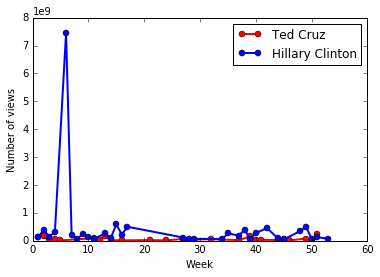

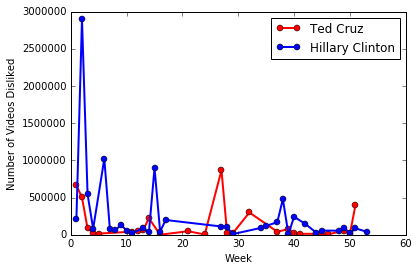

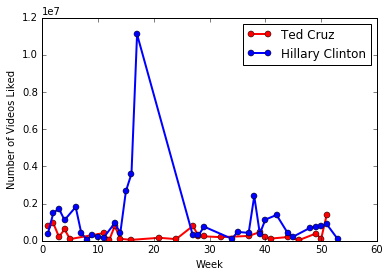

In [113]:
for candidate, color in zip(['Ted Cruz', 'Hillary Clinton'], ["r", "b"]):
    cand = presidential_data[presidential_data["candidate_name"]==candidate]
    by_date = cand["week"].value_counts()
    by_date = by_date.sort_index()
    dates = by_date.index
    plt.plot(dates, by_date.values, "-o", label=candidate, c=color, linewidth=2)
plt.legend(loc="best")
plt.ylabel("Videos Published")
plt.xlabel("Week")
plt.show()


for candidate, color in zip(['Ted Cruz', 'Hillary Clinton'], ["r", "b"]):
    cand = presidential_data[presidential_data["candidate_name"]==candidate]
    by_date = pd.pivot_table(cand, index =["week"], values=["view_count"], aggfunc="sum")
    by_date = by_date.sort_index()
    dates = by_date.index
    plt.plot(dates, by_date.values, "-o", label=candidate, c=color, linewidth=2)
plt.legend(loc="best")
plt.ylabel("Number of views")
plt.xlabel("Week")
plt.show()


for candidate, color in zip(['Ted Cruz', 'Hillary Clinton'], ["r", "b"]):
    cand = presidential_data[presidential_data["candidate_name"]==candidate]
    by_date = pd.pivot_table(cand, index =["week"], values=["dislike_count"], aggfunc="sum")
    by_date = by_date.sort_index()
    dates = by_date.index
    plt.plot(dates, by_date.values, "-o", label=candidate, c=color, linewidth=2)
plt.legend(loc="best")
plt.ylabel("Number of Videos Disliked")
plt.xlabel("Week")
plt.show()


for candidate, color in zip(['Ted Cruz', 'Hillary Clinton'], ["r", "b"]):
    cand = presidential_data[presidential_data["candidate_name"]==candidate]
    by_date = pd.pivot_table(cand, index =["week"], values=["like_count"], aggfunc="sum")
    by_date = by_date.sort_index()
    dates = by_date.index
    plt.plot(dates, by_date.values, "-o", label=candidate, c=color, linewidth=2)
plt.legend(loc="best")
plt.ylabel("Number of Videos Liked")
plt.xlabel("Week")
plt.show()

### Observations: 
1. In the first 10 weeks of our analysis, there were more than double videos about Ted Cruz posted on youtube. However, videos about Hillary Clinton got far more dislikes and views than that of Ted Cruz. 
2. In Week 20 of our analysis, far more videos about Hillary were on youtube and they also garnered more likes than those of Ted Cruz. 
3. In recent weeks leading to Iowa caucus, there were more videos about Ted Cruz on youtube that of Hillary Clinton. However, they got almost close to same number of views, dislikes and likes

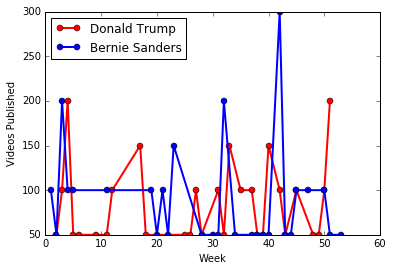

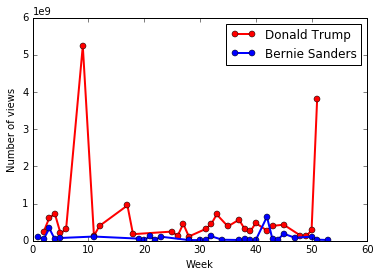

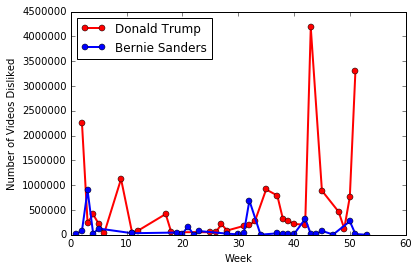

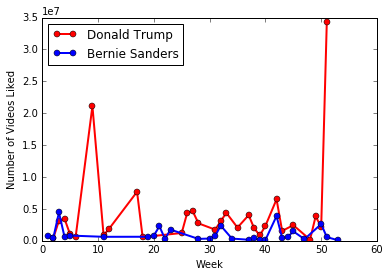

In [114]:
for candidate, color in zip(['Donald Trump', 'Bernie Sanders'], ["r", "b"]):
    cand = presidential_data[presidential_data["candidate_name"]==candidate]
    by_date = cand["week"].value_counts()
    by_date = by_date.sort_index()
    dates = by_date.index
    plt.plot(dates, by_date.values, "-o", label=candidate, c=color, linewidth=2)
plt.legend(loc="best")
plt.ylabel("Videos Published")
plt.xlabel("Week")
plt.show()


for candidate, color in zip(['Donald Trump', 'Bernie Sanders'], ["r", "b"]):
    cand = presidential_data[presidential_data["candidate_name"]==candidate]
    by_date = pd.pivot_table(cand, index =["week"], values=["view_count"], aggfunc="sum")
    by_date = by_date.sort_index()
    dates = by_date.index
    plt.plot(dates, by_date.values, "-o", label=candidate, c=color, linewidth=2)
plt.legend(loc="best")
plt.ylabel("Number of views")
plt.xlabel("Week")
plt.show()


for candidate, color in zip(['Donald Trump', 'Bernie Sanders'], ["r", "b"]):
    cand = presidential_data[presidential_data["candidate_name"]==candidate]
    by_date = pd.pivot_table(cand, index =["week"], values=["dislike_count"], aggfunc="sum")
    by_date = by_date.sort_index()
    dates = by_date.index
    plt.plot(dates, by_date.values, "-o", label=candidate, c=color, linewidth=2)
plt.legend(loc="best")
plt.ylabel("Number of Videos Disliked")
plt.xlabel("Week")
plt.show()


for candidate, color in zip(['Donald Trump', 'Bernie Sanders'], ["r", "b"]):
    cand = presidential_data[presidential_data["candidate_name"]==candidate]
    by_date = pd.pivot_table(cand, index =["week"], values=["like_count"], aggfunc="sum")
    by_date = by_date.sort_index()
    dates = by_date.index
    plt.plot(dates, by_date.values, "-o", label=candidate, c=color, linewidth=2)
plt.legend(loc="best")
plt.ylabel("Number of Videos Liked")
plt.xlabel("Week")
plt.show()

### Observations: 
1.	In Week 1 through 5 in our analysis, almost same number of videos were published about Bernie Sanders and Donald Trump. However, Bernie Sanders had far less dislikes and few more likes than Donald Trump. 
2.	There was a huge upshot in the number of views of Donald Turmp’s videos in Weeks 5 -10
3.	In the weeks leading to Iowa caucus, there were far more videos about Donald Trump on youtube. And, they garnered far more likes than dislikes. There were far fewer videos about Bernie Sanders and they garnered close to equal number of likes and dislikes


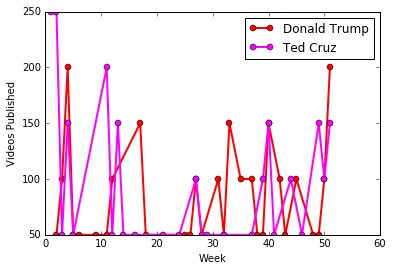

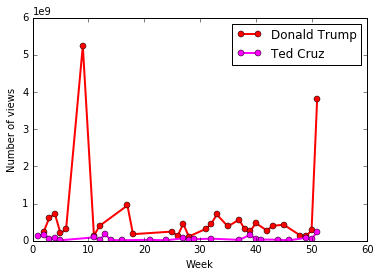

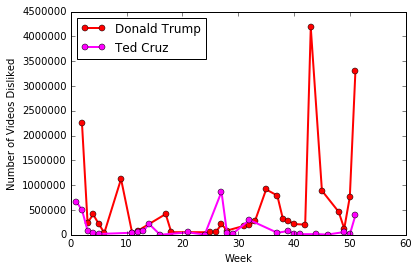

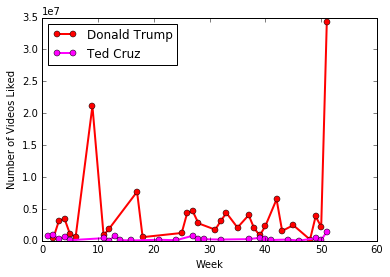

In [115]:
for candidate, color in zip(['Donald Trump', 'Ted Cruz'], ["red", "magenta"]):
    cand = presidential_data[presidential_data["candidate_name"]==candidate]
    by_date = cand["week"].value_counts()
    by_date = by_date.sort_index()
    dates = by_date.index
    plt.plot(dates, by_date.values, "-o", label=candidate, c=color, linewidth=2)
plt.legend(loc="best")
plt.ylabel("Videos Published")
plt.xlabel("Week")
plt.show()


for candidate, color in zip(['Donald Trump', 'Ted Cruz'], ["red", "magenta"]):
    cand = presidential_data[presidential_data["candidate_name"]==candidate]
    by_date = pd.pivot_table(cand, index =["week"], values=["view_count"], aggfunc="sum")
    by_date = by_date.sort_index()
    dates = by_date.index
    plt.plot(dates, by_date.values, "-o", label=candidate, c=color, linewidth=2)
plt.legend(loc="best")
plt.ylabel("Number of views")
plt.xlabel("Week")
plt.show()


for candidate, color in zip(['Donald Trump', 'Ted Cruz'], ["red", "magenta"]):
    cand = presidential_data[presidential_data["candidate_name"]==candidate]
    by_date = pd.pivot_table(cand, index =["week"], values=["dislike_count"], aggfunc="sum")
    by_date = by_date.sort_index()
    dates = by_date.index
    plt.plot(dates, by_date.values, "-o", label=candidate, c=color, linewidth=2)
plt.legend(loc="best")
plt.ylabel("Number of Videos Disliked")
plt.xlabel("Week")
plt.show()


for candidate, color in zip(['Donald Trump', 'Ted Cruz'], ["red", "magenta"]):
    cand = presidential_data[presidential_data["candidate_name"]==candidate]
    by_date = pd.pivot_table(cand, index =["week"], values=["like_count"], aggfunc="sum")
    by_date = by_date.sort_index()
    dates = by_date.index
    plt.plot(dates, by_date.values, "-o", label=candidate, c=color, linewidth=2)
plt.legend(loc="best")
plt.ylabel("Number of Videos Liked")
plt.xlabel("Week")
plt.show()

### Observations: 
1.	Even though Donald Trump and Ted Cruz seem to have got same amount of coverage on youtube in terms of videos published, Donald Trump has received extremely high number of views from weeks 5-10 and during the weeks leading to Iowa caucus
2.	Even though videos about Donald Trump were far much favored as compared to that of Ted Cruz in initial weeks, there was an upshot in the number of dislikes and likes in weeks leading to the Iowa caucus
3.	Overall it seems that while videos about Ted Cruz have had fairly similar statistics throughout the time window of our analysis, statistics for videos about Donald Trump have been varying a lot


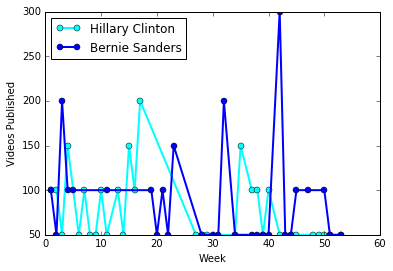

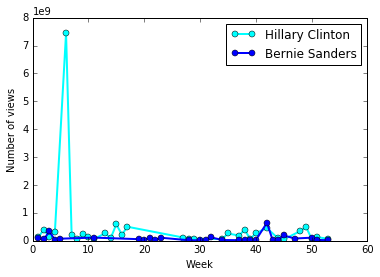

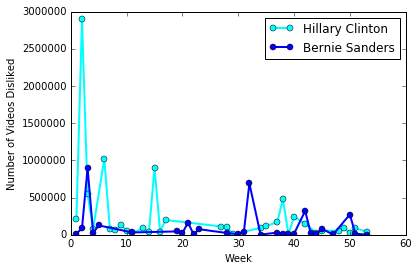

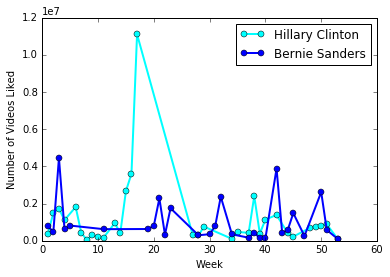

In [116]:
for candidate, color in zip(['Hillary Clinton', 'Bernie Sanders'], ["cyan", "blue"]):
    cand = presidential_data[presidential_data["candidate_name"]==candidate]
    by_date = cand["week"].value_counts()
    by_date = by_date.sort_index()
    dates = by_date.index
    plt.plot(dates, by_date.values, "-o", label=candidate, c=color, linewidth=2)
plt.legend(loc="best")
plt.ylabel("Videos Published")
plt.xlabel("Week")
plt.show()


for candidate, color in zip(['Hillary Clinton', 'Bernie Sanders'], ["cyan", "blue"]):
    cand = presidential_data[presidential_data["candidate_name"]==candidate]
    by_date = pd.pivot_table(cand, index =["week"], values=["view_count"], aggfunc="sum")
    by_date = by_date.sort_index()
    dates = by_date.index
    plt.plot(dates, by_date.values, "-o", label=candidate, c=color, linewidth=2)
plt.legend(loc="best")
plt.ylabel("Number of views")
plt.xlabel("Week")
plt.show()


for candidate, color in zip(['Hillary Clinton', 'Bernie Sanders'], ["cyan", "blue"]):
    cand = presidential_data[presidential_data["candidate_name"]==candidate]
    by_date = pd.pivot_table(cand, index =["week"], values=["dislike_count"], aggfunc="sum")
    by_date = by_date.sort_index()
    dates = by_date.index
    plt.plot(dates, by_date.values, "-o", label=candidate, c=color, linewidth=2)
plt.legend(loc="best")
plt.ylabel("Number of Videos Disliked")
plt.xlabel("Week")
plt.show()


for candidate, color in zip(['Hillary Clinton', 'Bernie Sanders'], ["cyan", "blue"]):
    cand = presidential_data[presidential_data["candidate_name"]==candidate]
    by_date = pd.pivot_table(cand, index =["week"], values=["like_count"], aggfunc="sum")
    by_date = by_date.sort_index()
    dates = by_date.index
    plt.plot(dates, by_date.values, "-o", label=candidate, c=color, linewidth=2)
plt.legend(loc="best")
plt.ylabel("Number of Videos Liked")
plt.xlabel("Week")
plt.show()

### Observations: 
1. Even though both Bernie Sanders and Hillary Clinton started out with almost similar number of videos being published on youtube, Hillary Clinton got far more views and dislikes and far less likes than Bernie Sanders in starting weeks.
2. Hillary Clinton's favorability (number of likes) had an upshot in week 20 
3. In weeks leading to the Iowa caucus, Bernie Sanders has received more attention (number of videos published) on youtube

### Conculsion: 
1. Youtube statistics alone is by no means a decent indicator of favorability outcomes

### Future Work: 
1. Apart from looking at the raw statistics from youtube, we should also analyze the text of video description. Example: Hillary supporters may dislike videos with descriptions that may sound to discount her credibilities
2. We should also gather and analyze comments to look at positive, negative or neutral tone towards the posted videos